In [1]:
# Import Python modules
import os, sys
import yaml
import numpy as np
import pandas as  pd
import xarray as xr
from datetime import timedelta, date
import textwrap

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# other
from scipy.ndimage import gaussian_filter    # smoothing contour lines

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from ar_funcs import get_ar_days, duration_stats
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
server = "skyriver"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## read clim data
varname_lst = ['huv', 'ivt', 'mslp']
ds_lst = []
for i, varname in enumerate(varname_lst):
    fname = path_to_data + 'preprocessed/ERA5_{0}_clim.nc'.format(varname)
    ds = xr.open_dataset(fname)
    del ds.attrs['history']
    ds_lst.append(ds)
ds_final = xr.combine_by_coords(ds_lst)
ds_final

<xarray.Dataset>
Dimensions:  (lon: 281, lat: 245, season: 4)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... -110.5 -110.2 -110.0
  * lat      (lat) float32 80.0 79.75 79.5 79.25 79.0 ... 19.75 19.5 19.25 19.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
    level    int32 ...
Data variables:
    IVTv     (season, lat, lon) float32 ...
    IVTu     (season, lat, lon) float32 ...
    IVT      (season, lat, lon) float32 ...
    msl      (season, lat, lon) float32 ...
    z        (season, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6

In [4]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds_final.lat.values
lons = ds_final.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

# ext1 = [-141., -130., 54., 61.] # extent of SEAK
ext1 = [-180., -110., 19, 80] # extent of CIMSS Plots

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

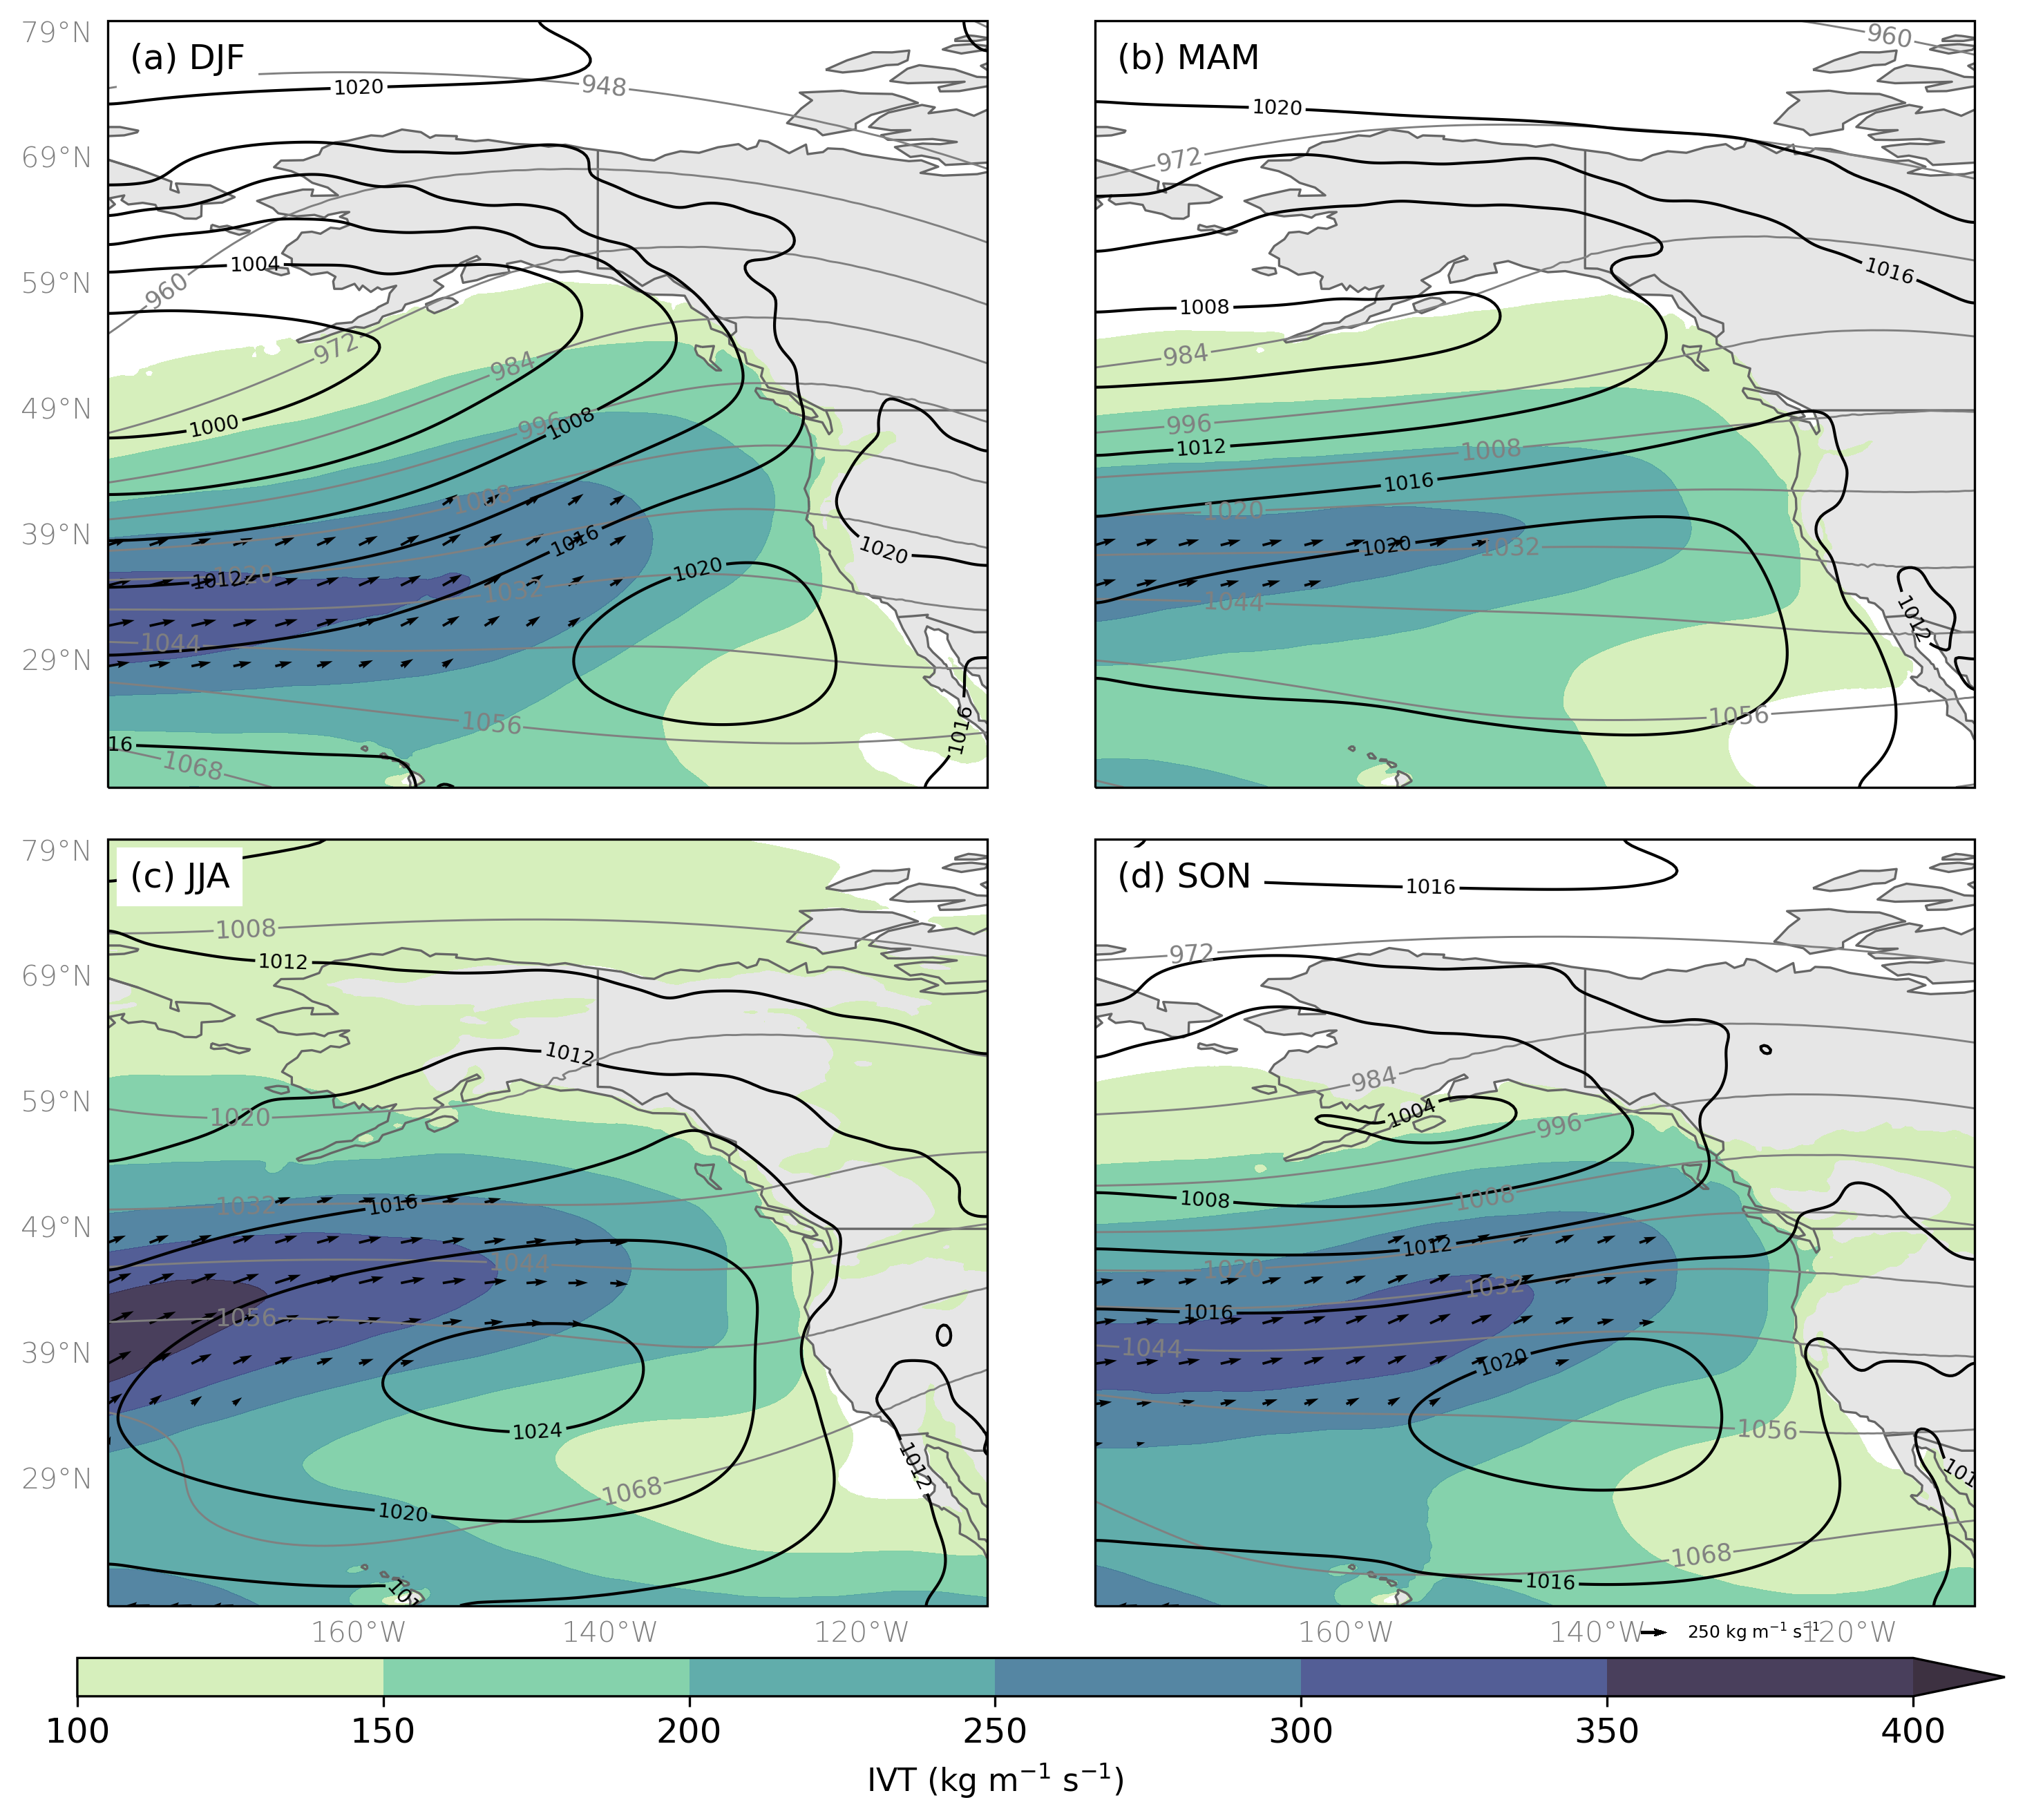

In [6]:
# Create figure
fig = plt.figure(figsize=(12, 10.5))
fig.dpi = 300
fname = path_to_figs + 'synoptic_ssn_composite'
fmt = 'png'

nrows = 3
ncols = 2

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05], width_ratios = [1, 1], wspace=0.05, hspace=0.1)
## use gs[rows index, columns index] to access grids

###########################
### SEASONAL COMPOSITES ###
###########################
left_lat_lst = [True, False]*2
bottom_lat_lst = [False, False, True , True]
rowidx_lst = [0, 0, 1, 1]
colidx_lst = [0, 1, 0, 1]
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
for k, (colidx, rowidx) in enumerate(zip(colidx_lst, rowidx_lst)):
    ax = fig.add_subplot(gs[rowidx, colidx], projection=mapcrs)
    
    ds = ds_final.sel(season=ssn_lst[k])
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=left_lat_lst[k], right_lats=False, bottom_lons=bottom_lat_lst[k])

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.IVTu.values
    vvec = ds.IVTv.values
    uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # ax.set_title(community_lst[k], loc='left', fontsize=10)
    titlestring = '({0}) {1}'.format(letter_lst[k], ssn_lst[k])
    ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    # Contour Lines
    hgts = ds.z.values/(100) # convert to dekameters # 250-hPa Heights
    clevs = np.arange(696, 1280, 12)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)
    
    # Plot MSLP
    clevs_slp = np.arange(800., 1120., 4)
    slp_smooth = gaussian_filter(ds.msl.values/100., sigma=4)
    cs2 = ax.contour(lons, lats, slp_smooth, transform=datacrs,
                     levels=clevs_slp, colors='k',
                     linewidths=1., linestyles='solid')
    plt.clabel(cs2, **kw_clabels)
    
# quiver key
qk = ax.quiverkey(Q, 0.65, -0.035, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})


# Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()